# Chapter 4: Default Archetype Analysis

In [24]:
import sys
from pathlib import Path
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display, HTML

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score

import umap

PROJ_ROOT = Path.cwd().parent
if str(PROJ_ROOT) not in sys.path:
    sys.path.append(str(PROJ_ROOT))

from credit_risk_xai.config import ACTIVE_MODEL_VERSION, ACTIVE_FEATURES, get_display_name

sns.set_style('whitegrid')
print(f"Model version: {ACTIVE_MODEL_VERSION} ({len(ACTIVE_FEATURES)} features)")

Model version: v2 (22 features)


## 1. Load SHAP Cache and Filter to Defaults

In [26]:
cache_file = PROJ_ROOT / "results" / "xai_exploration" / "shap_cache.pkl"
with open(cache_file, 'rb') as f:
    shap_cache = pickle.load(f)

X_val = shap_cache['X_val']
y_val = shap_cache['y_val']
y_pred_lgbm = shap_cache['y_pred_proba_lgbm']
y_pred_logit = shap_cache['y_pred_proba_logit']
shap_values_lgbm = shap_cache['shap_values_lgbm']
feature_names = shap_cache['feature_names']

DEFAULTS_ONLY = False  # Toggle: True = defaults only, False = all samples

if DEFAULTS_ONLY:
    default_mask = y_val.values == 1
else:
    default_mask = np.ones(len(y_val), dtype=bool)  # All True
    
X_defaults = X_val[default_mask]
shap_defaults = shap_values_lgbm[default_mask]
pd_defaults_lgbm = y_pred_lgbm[default_mask]
pd_defaults_logit = y_pred_logit[default_mask]

## 2. Preprocessing for Clustering

Steps:
1. **Standardize SHAP values** - Scale to unit variance
2. **PCA** - Reduce dimensionality while preserving 95% variance
3. **UMAP** - Create 2D embedding for visualization

Note: With ~1,000 defaults (vs 60,000 total firms), we can use faster settings.

In [27]:
scaler = StandardScaler()
shap_scaled = scaler.fit_transform(shap_defaults)

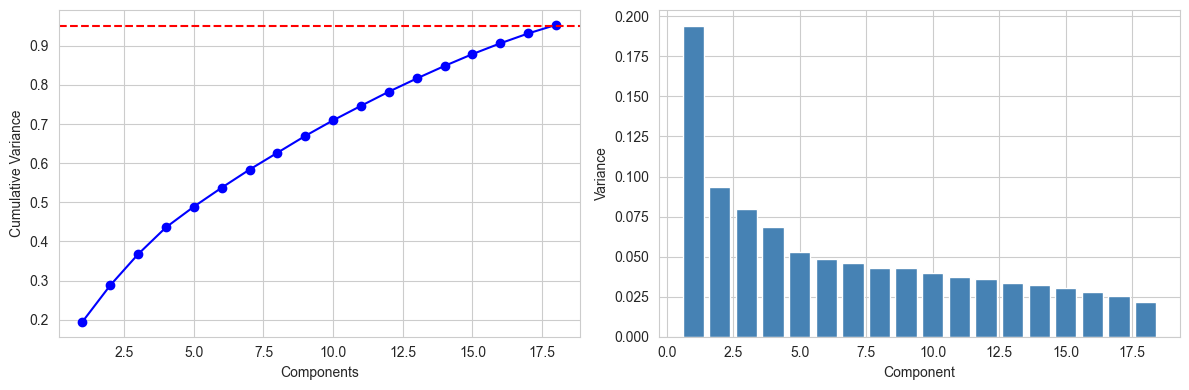

In [28]:
pca = PCA(n_components=0.95, random_state=42)
shap_pca = pca.fit_transform(shap_scaled)

fig, axes = plt.subplots(1, 2, figsize=(12, 4))
cumvar = np.cumsum(pca.explained_variance_ratio_)
axes[0].plot(range(1, len(cumvar)+1), cumvar, 'bo-')
axes[0].axhline(y=0.95, color='r', linestyle='--')
axes[0].set_xlabel('Components')
axes[0].set_ylabel('Cumulative Variance')

axes[1].bar(range(1, len(pca.explained_variance_ratio_)+1), pca.explained_variance_ratio_, color='steelblue')
axes[1].set_xlabel('Component')
axes[1].set_ylabel('Variance')
plt.tight_layout()
plt.show()

In [29]:
reducer = umap.UMAP(n_components=2, random_state=42, n_neighbors=15, min_dist=0.1, metric='euclidean')
shap_2d = reducer.fit_transform(shap_pca)

/Users/vilhelmkarlin/Code/HHS/BE451_Thesis/credit-risk-xai-thesis/.venv/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


## 3. Determine Optimal Number of Clusters

With ~1,000 defaults, we test k=2 to 6 (fewer clusters than before due to smaller sample size).

Evaluation metrics:
- **Elbow method**: Inertia (within-cluster sum of squares)
- **Silhouette score**: Measure of cluster cohesion and separation
- **Davies-Bouldin index**: Ratio of within-cluster to between-cluster distances

In [30]:
K_range = range(2, 7)
results = []

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = kmeans.fit_predict(shap_pca)
    results.append({
        'k': k,
        'inertia': kmeans.inertia_,
        'silhouette': silhouette_score(shap_pca, labels),
        'davies_bouldin': davies_bouldin_score(shap_pca, labels)
    })

results_df = pd.DataFrame(results)
HTML(results_df.to_html(index=False))

k,inertia,silhouette,davies_bouldin
2,1.089556e+06,0.176688,2.322245
3,1.023664e+06,0.126475,2.612268
4,9.753092e+05,0.124317,2.560992
5,9.429765e+05,0.071616,2.627950
6,9.131416e+05,0.070298,2.588292


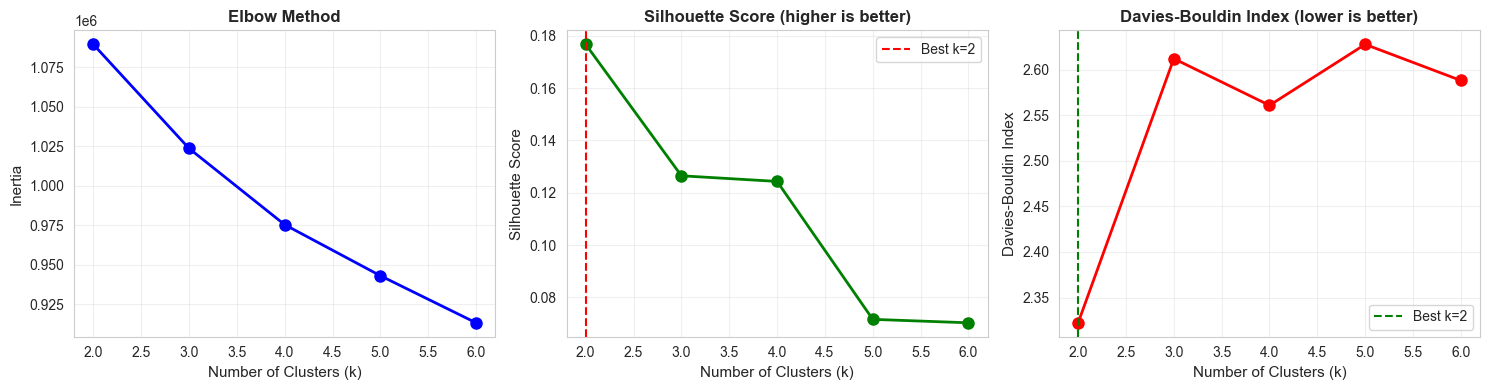

In [31]:
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

axes[0].plot(results_df['k'], results_df['inertia'], 'bo-', linewidth=2, markersize=8)
axes[0].set_xlabel('Number of Clusters (k)', fontsize=11)
axes[0].set_ylabel('Inertia', fontsize=11)
axes[0].set_title('Elbow Method', fontsize=12, fontweight='bold')
axes[0].grid(alpha=0.3)

best_k_silhouette = int(results_df.loc[results_df['silhouette'].idxmax(), 'k'])
axes[1].plot(results_df['k'], results_df['silhouette'], 'go-', linewidth=2, markersize=8)
axes[1].axvline(x=best_k_silhouette, color='r', linestyle='--', label=f'Best k={best_k_silhouette}')
axes[1].set_xlabel('Number of Clusters (k)', fontsize=11)
axes[1].set_ylabel('Silhouette Score', fontsize=11)
axes[1].set_title('Silhouette Score (higher is better)', fontsize=12, fontweight='bold')
axes[1].legend()
axes[1].grid(alpha=0.3)

best_k_db = int(results_df.loc[results_df['davies_bouldin'].idxmin(), 'k'])
axes[2].plot(results_df['k'], results_df['davies_bouldin'], 'ro-', linewidth=2, markersize=8)
axes[2].axvline(x=best_k_db, color='g', linestyle='--', label=f'Best k={best_k_db}')
axes[2].set_xlabel('Number of Clusters (k)', fontsize=11)
axes[2].set_ylabel('Davies-Bouldin Index', fontsize=11)
axes[2].set_title('Davies-Bouldin Index (lower is better)', fontsize=12, fontweight='bold')
axes[2].legend()
axes[2].grid(alpha=0.3)

plt.tight_layout()
plt.show()

In [32]:
k_optimal = 2

## 4. K-Means Clustering of Default Archetypes

In [33]:
kmeans_final = KMeans(n_clusters=k_optimal, random_state=42, n_init=10, max_iter=300)
cluster_labels = kmeans_final.fit_predict(shap_pca)

cluster_df = pd.DataFrame({
    'cluster': cluster_labels,
    'pd_lgbm': pd_defaults_lgbm,
    'pd_logit': pd_defaults_logit
}, index=X_defaults.index)

cluster_df['umap_x'] = shap_2d[:, 0]
cluster_df['umap_y'] = shap_2d[:, 1]

cluster_sizes = cluster_df['cluster'].value_counts().sort_index()
HTML(cluster_sizes.to_frame().to_html(index=False))

count
22867
37963


## 5. Default Archetype Characterization

For each archetype, we analyze:
1. Predicted PD distribution (how "expected" were these defaults?)
2. SHAP value profile (which features drove default in this group?)
3. Distinguishing characteristics (what makes this archetype unique?)

In [34]:
cluster_summary = cluster_df.groupby('cluster').agg({
    'pd_lgbm': ['count', 'mean', 'median', 'std', 'min', 'max'],
    'pd_logit': 'mean'
}).round(4)

cluster_summary.columns = ['Size', 'Mean_PD_LightGBM', 'Median_PD_LightGBM', 
                           'Std_PD_LightGBM', 'Min_PD_LightGBM', 'Max_PD_LightGBM',
                           'Mean_PD_Logit']

cluster_summary['Pct_of_Defaults'] = (cluster_summary['Size'] / len(cluster_df) * 100).round(1)
HTML(cluster_summary.to_html(index=False))

Size,Mean_PD_LightGBM,Median_PD_LightGBM,Std_PD_LightGBM,Min_PD_LightGBM,Max_PD_LightGBM,Mean_PD_Logit,Pct_of_Defaults
22867,0.0429,0.0205,0.0620,0.0006,0.6552,0.0410,37.6
37963,0.0020,0.0009,0.0031,0.0001,0.0578,0.0036,62.4


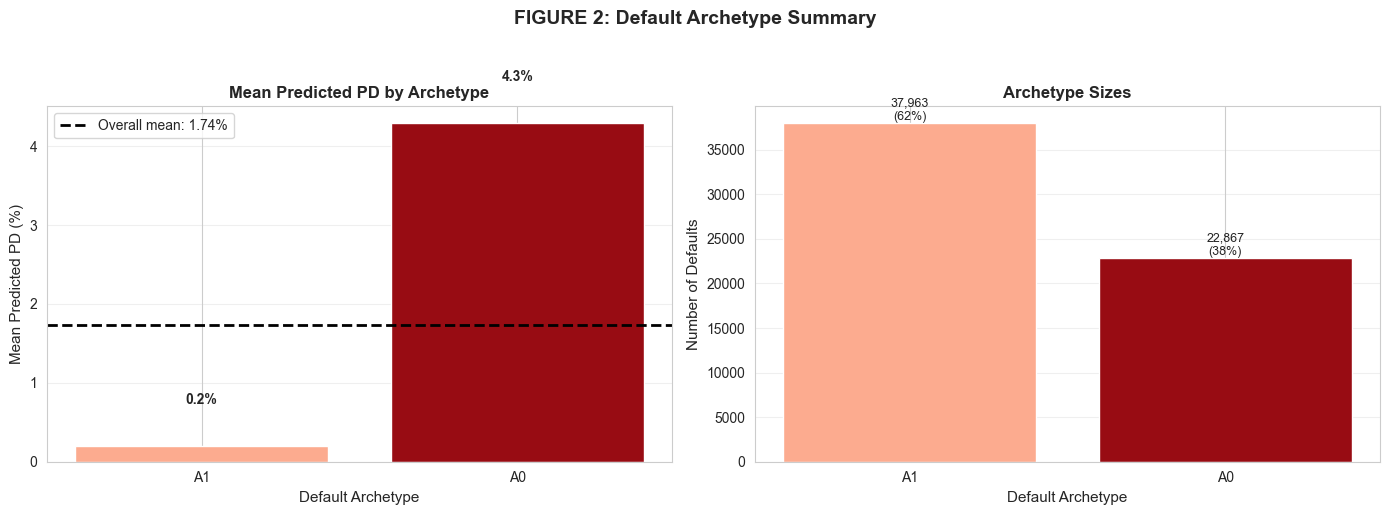

In [35]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Sort archetypes by mean predicted PD
cluster_order = cluster_summary.sort_values('Mean_PD_LightGBM').index.tolist()
colors = plt.cm.Reds(np.linspace(0.3, 0.9, k_optimal))

# 1. Mean predicted PD bar chart
sorted_pds = cluster_summary.loc[cluster_order, 'Mean_PD_LightGBM']
bars = axes[0].bar(range(k_optimal), sorted_pds * 100, color=colors)
axes[0].axhline(y=cluster_df['pd_lgbm'].mean()*100, color='black', linestyle='--', 
                linewidth=2, label=f'Overall mean: {cluster_df["pd_lgbm"].mean()*100:.2f}%')
axes[0].set_xticks(range(k_optimal))
axes[0].set_xticklabels([f'A{c}' for c in cluster_order])
axes[0].set_xlabel('Default Archetype', fontsize=11)
axes[0].set_ylabel('Mean Predicted PD (%)', fontsize=11)
axes[0].set_title('Mean Predicted PD by Archetype', fontsize=12, fontweight='bold')
axes[0].legend(loc='upper left')
axes[0].grid(alpha=0.3, axis='y')

for bar, pd_val in zip(bars, sorted_pds):
    axes[0].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5,
                f'{pd_val*100:.1f}%', ha='center', va='bottom', fontsize=10, fontweight='bold')

# 2. Archetype sizes
sorted_sizes = cluster_summary.loc[cluster_order, 'Size']
bars2 = axes[1].bar(range(k_optimal), sorted_sizes, color=colors)
axes[1].set_xticks(range(k_optimal))
axes[1].set_xticklabels([f'A{c}' for c in cluster_order])
axes[1].set_xlabel('Default Archetype', fontsize=11)
axes[1].set_ylabel('Number of Defaults', fontsize=11)
axes[1].set_title('Archetype Sizes', fontsize=12, fontweight='bold')
axes[1].grid(alpha=0.3, axis='y')

for bar, size in zip(bars2, sorted_sizes):
    pct = size / len(cluster_df) * 100
    axes[1].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 5,
                f'{size:,}\n({pct:.0f}%)', ha='center', va='bottom', fontsize=9)

plt.suptitle('FIGURE 2: Default Archetype Summary', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

In [36]:
shap_df = pd.DataFrame(shap_defaults, columns=feature_names, index=X_defaults.index)
shap_df['cluster'] = cluster_labels

cluster_shap_means = shap_df.groupby('cluster')[feature_names].mean()
overall_default_shap = shap_df[feature_names].mean()

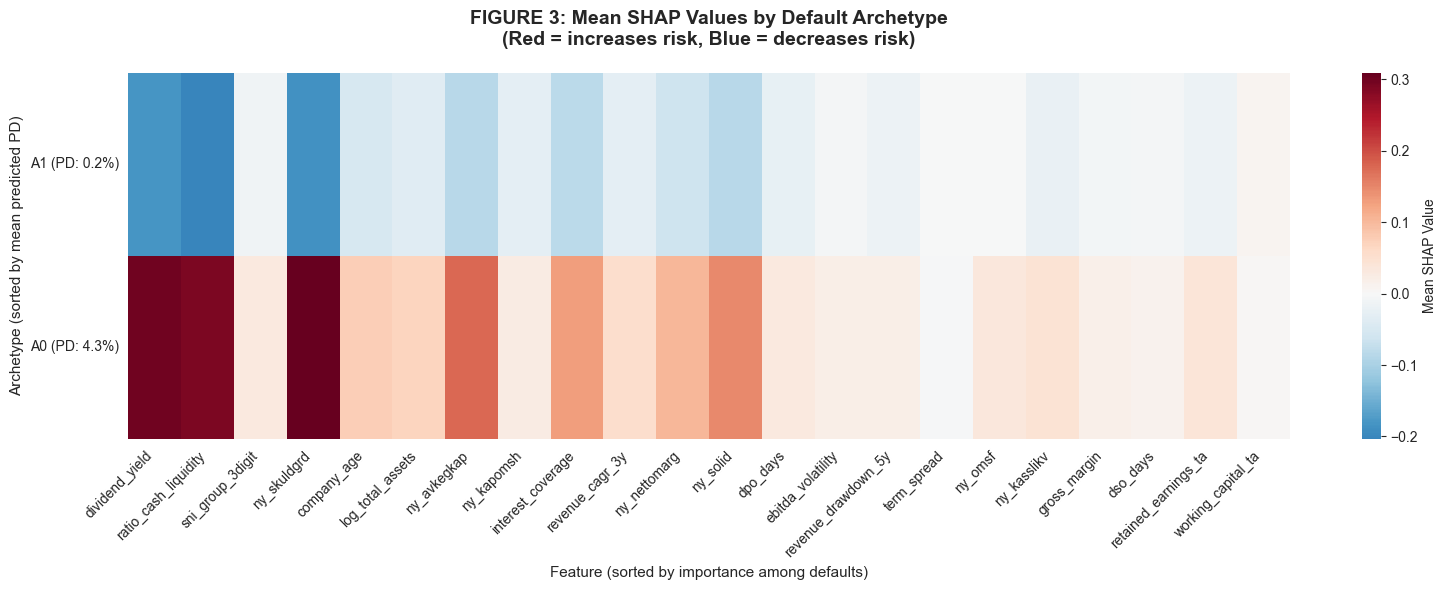

In [37]:
fig, ax = plt.subplots(figsize=(16, 6))

# Sort features by overall importance (mean absolute SHAP across defaults)
feature_importance = np.abs(shap_defaults).mean(axis=0)
sorted_features = [feature_names[i] for i in np.argsort(feature_importance)[::-1]]

# Reorder columns
cluster_shap_sorted = cluster_shap_means[sorted_features]

# Sort rows by mean predicted PD
cluster_order_by_pd = cluster_summary.sort_values('Mean_PD_LightGBM').index.tolist()
cluster_shap_sorted = cluster_shap_sorted.loc[cluster_order_by_pd]

# Create heatmap
sns.heatmap(
    cluster_shap_sorted,
    annot=False,
    cmap='RdBu_r',
    center=0,
    ax=ax,
    cbar_kws={'label': 'Mean SHAP Value'}
)

# Add PD annotation to y-axis
ytick_labels = [f"A{c} (PD: {cluster_summary.loc[c, 'Mean_PD_LightGBM']*100:.1f}%)" 
                for c in cluster_order_by_pd]
ax.set_yticklabels(ytick_labels, rotation=0)

ax.set_xlabel('Feature (sorted by importance among defaults)', fontsize=11)
ax.set_ylabel('Archetype (sorted by mean predicted PD)', fontsize=11)
ax.set_title('FIGURE 3: Mean SHAP Values by Default Archetype\n(Red = increases risk, Blue = decreases risk)',
             fontsize=14, fontweight='bold', pad=20)

plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [38]:
archetype_descriptions = {}
cluster_order_by_pd = cluster_summary.sort_values('Mean_PD_LightGBM').index.tolist()

for cluster_id in cluster_order_by_pd:
    cluster_shap = cluster_shap_means.loc[cluster_id]
    top_positive = cluster_shap.nlargest(5)
    top_negative = cluster_shap.nsmallest(3)
    
    archetype_descriptions[cluster_id] = {
        'top_risk_drivers': top_positive.index.tolist()[:3],
        'mean_pd': cluster_summary.loc[cluster_id, 'Mean_PD_LightGBM'],
        'size': int(cluster_summary.loc[cluster_id, 'Size'])
    }

/var/folders/5c/7nyvkw450d38pmzqgbgq75wc0000gn/T/ipykernel_32490/3342567252.py:29: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  legend_elements = [plt.scatter([], [], c=plt.cm.tab10(i/10), s=50,


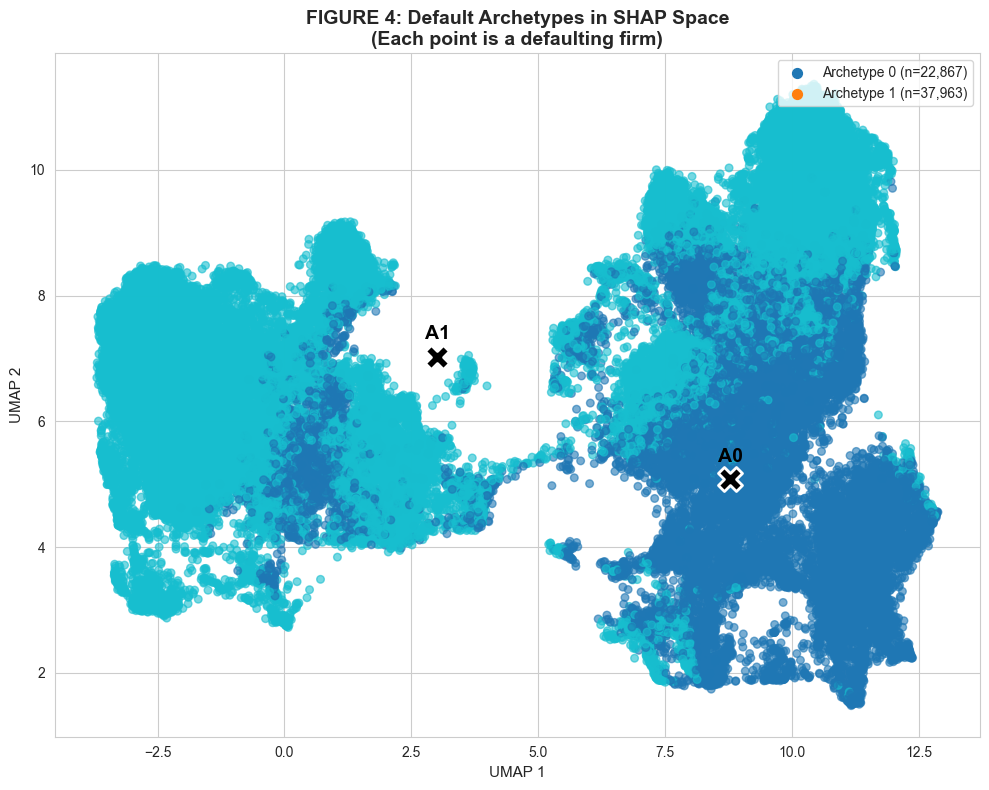

Note: Clusters represent different 'pathways to default' based on SHAP profiles.


In [39]:
fig, ax = plt.subplots(figsize=(10, 8))

# Color by archetype
scatter = ax.scatter(
    cluster_df['umap_x'], 
    cluster_df['umap_y'],
    c=cluster_df['cluster'],
    cmap='tab10',
    alpha=0.6,
    s=30
)

# Add archetype centers
for c in range(k_optimal):
    mask = cluster_df['cluster'] == c
    cx = cluster_df.loc[mask, 'umap_x'].mean()
    cy = cluster_df.loc[mask, 'umap_y'].mean()
    ax.scatter([cx], [cy], c='black', s=300, marker='X', edgecolors='white', linewidths=2, zorder=10)
    ax.annotate(f'A{c}', (cx, cy), fontsize=14, fontweight='bold', 
                ha='center', va='bottom', color='black',
                xytext=(0, 10), textcoords='offset points')

ax.set_xlabel('UMAP 1', fontsize=11)
ax.set_ylabel('UMAP 2', fontsize=11)
ax.set_title('FIGURE 4: Default Archetypes in SHAP Space\n(Each point is a defaulting firm)', 
             fontsize=14, fontweight='bold')

# Add legend
legend_elements = [plt.scatter([], [], c=plt.cm.tab10(i/10), s=50, 
                               label=f'Archetype {i} (n={int(cluster_summary.loc[i, "Size"]):,})')
                   for i in range(k_optimal)]
ax.legend(handles=legend_elements, loc='upper right', fontsize=10)

plt.tight_layout()
plt.show()

print("Note: Clusters represent different 'pathways to default' based on SHAP profiles.")

## 6. Archetype Deep Dive: PD Distributions

How "expected" were these defaults? Archetypes with low predicted PD represent "surprise" defaults that the model failed to anticipate.

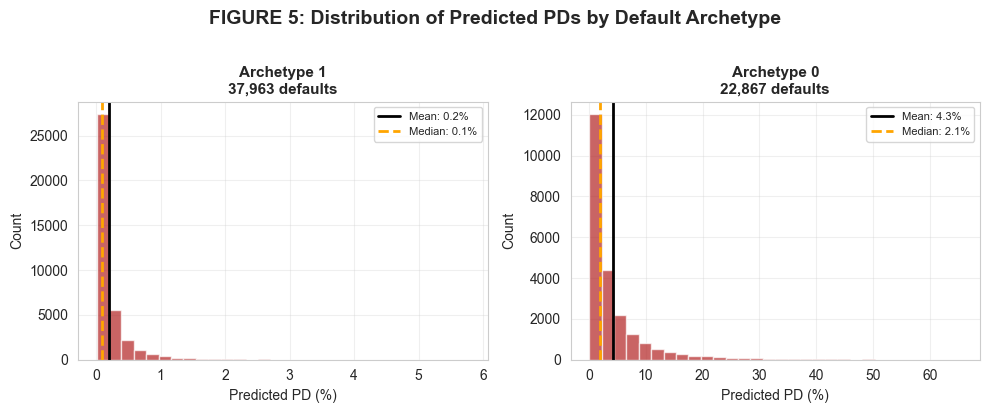


'Surprise' defaults (PD < 5%): 55,129 (90.6%)
These are firms the model did not expect to default.


In [40]:
n_cols = min(k_optimal, 3)
n_rows = (k_optimal + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(5*n_cols, 4*n_rows))
if k_optimal > 1:
    axes = axes.flatten() if n_rows > 1 or n_cols > 1 else [axes]
else:
    axes = [axes]

for i, cluster_id in enumerate(cluster_order_by_pd):
    ax = axes[i]
    cluster_data = cluster_df[cluster_df['cluster'] == cluster_id]
    
    # Histogram of PDs
    ax.hist(cluster_data['pd_lgbm'] * 100, bins=30, color='firebrick', 
            alpha=0.7, edgecolor='white')
    
    # Add vertical lines for mean and median
    mean_pd = cluster_data['pd_lgbm'].mean() * 100
    median_pd = cluster_data['pd_lgbm'].median() * 100
    ax.axvline(x=mean_pd, color='black', linestyle='-', linewidth=2, label=f'Mean: {mean_pd:.1f}%')
    ax.axvline(x=median_pd, color='orange', linestyle='--', linewidth=2, label=f'Median: {median_pd:.1f}%')
    
    size = int(cluster_summary.loc[cluster_id, 'Size'])
    ax.set_xlabel('Predicted PD (%)', fontsize=10)
    ax.set_ylabel('Count', fontsize=10)
    ax.set_title(f'Archetype {cluster_id}\n{size:,} defaults', 
                 fontsize=11, fontweight='bold')
    ax.legend(fontsize=8)
    ax.grid(alpha=0.3)

# Hide unused subplots
for j in range(i+1, len(axes)):
    axes[j].axis('off')

plt.suptitle('FIGURE 5: Distribution of Predicted PDs by Default Archetype', 
             fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

# Identify "surprise" defaults
low_pd_threshold = 0.05  # 5%
surprise_defaults = cluster_df[cluster_df['pd_lgbm'] < low_pd_threshold]
print(f"\n'Surprise' defaults (PD < {low_pd_threshold*100:.0f}%): {len(surprise_defaults):,} ({len(surprise_defaults)/len(cluster_df)*100:.1f}%)")
print("These are firms the model did not expect to default.")

## 7. Archetype Naming and Interpretation

Based on the SHAP profiles, we assign descriptive names to each archetype.

In [41]:
archetype_profiles = []

for cluster_id in range(k_optimal):
    cluster_shap = cluster_shap_means.loc[cluster_id]
    top_drivers = cluster_shap.nlargest(3).index.tolist()
    
    mean_pd = cluster_summary.loc[cluster_id, 'Mean_PD_LightGBM']
    size = int(cluster_summary.loc[cluster_id, 'Size'])
    
    if mean_pd > 0.10:
        pd_category = "High PD (expected defaults)"
    elif mean_pd > 0.05:
        pd_category = "Medium PD"
    else:
        pd_category = "Low PD (surprise defaults)"
    
    archetype_profiles.append({
        'archetype': cluster_id,
        'size': size,
        'pct_of_defaults': round(size / len(cluster_df) * 100, 1),
        'mean_pd_pct': round(mean_pd * 100, 1),
        'pd_category': pd_category,
        'top_risk_driver_1': top_drivers[0],
        'top_risk_driver_2': top_drivers[1],
        'top_risk_driver_3': top_drivers[2]
    })

archetype_profiles_df = pd.DataFrame(archetype_profiles)
archetype_profiles_df = archetype_profiles_df.sort_values('mean_pd_pct', ascending=False)
print(archetype_profiles_df)

   archetype   size  pct_of_defaults  mean_pd_pct                 pd_category  \
0          0  22867             37.6          4.3  Low PD (surprise defaults)   
1          1  37963             62.4          0.2  Low PD (surprise defaults)   

    top_risk_driver_1 top_risk_driver_2     top_risk_driver_3  
0         ny_skuldgrd    dividend_yield  ratio_cash_liquidity  
1  working_capital_ta       term_spread               ny_omsf  


## 8. Summary & Key Findings

In [42]:
max_pd = cluster_summary['Mean_PD_LightGBM'].max()
min_pd = cluster_summary['Mean_PD_LightGBM'].min()
shap_variance = cluster_shap_means.var(axis=0).mean()
feature_variance = cluster_shap_means.var(axis=0).sort_values(ascending=False)

summary_df = pd.DataFrame({
    'Metric': [
        'Total defaults analyzed',
        'Number of archetypes',
        'Silhouette score',
        'PCA dimensions',
        'Highest archetype mean PD',
        'Lowest archetype mean PD',
        'PD spread',
        'Mean cross-archetype SHAP variance'
    ],
    'Value': [
        f"{len(cluster_df):,}",
        k_optimal,
        f"{results_df[results_df['k']==k_optimal]['silhouette'].values[0]:.4f}",
        f"{shap_defaults.shape[1]} → {shap_pca.shape[1]}",
        f"{max_pd*100:.1f}%",
        f"{min_pd*100:.1f}%",
        f"{(max_pd - min_pd)*100:.1f} pp",
        f"{shap_variance:.4f}"
    ]
})
HTML(summary_df.to_html(index=False))

Metric,Value
Total defaults analyzed,"60,830"
Number of archetypes,2
Silhouette score,0.1767
PCA dimensions,22 → 18
Highest archetype mean PD,4.3%
Lowest archetype mean PD,0.2%
PD spread,4.1 pp
Mean cross-archetype SHAP variance,0.0222


In [43]:
results_dir = PROJ_ROOT / "results" / "xai_clustering"
results_dir.mkdir(parents=True, exist_ok=True)

cluster_df.to_csv(results_dir / "cluster_assignments.csv")
cluster_summary.to_csv(results_dir / "cluster_summary.csv")
cluster_shap_means.to_csv(results_dir / "cluster_shap_profiles.csv")
archetype_profiles_df.to_csv(results_dir / "cluster_archetypes.csv", index=False)